# Introduction

This Python notebook showcases my solutions to the QOSF mentorship programme task.

## Caveat

While the algorithms themselves should be correct, there is a bug which causes all of the functions implemented to return `False`. This bug occurred because I was unable to get either the Aer or the Qasm simulators to work properly (simulating all circuits returns 0 [qu]bits everywhere regardless of the initial state), and I was unable to get them working due to time constraints (I'm currently in the middle of marking a large amount of coursework).

Therefore, the unit tests will fail, so please pay attention to the spirit of how my functions work instead of simply their output when run. The circuit diagrams I've built are also present in the appendices. :)

With that said, onto the task!

# Task

The task I have attempted to solve is task 2, which reads as follows:

> Given four positive integers $a$, $b$, $c$ and $d$, write a function `is_rectangle(a, b, c, d)` using a quantum circuit, which returns `True` if there exists a rectangle with side lengths $a$, $b$, $c$ and $d$ (in any order), and `False` otherwise.

A useful equivalence is that $a$, $b$, $c$ and $d$ form a rectangle if and only if there are two disjoint pairs of integers among them such that each integer is equal to its pair. This problem can therefore be reduced to "do there exist two mutually disjoint pairs $\alpha, \beta$ and $\gamma, \delta$ such that $\alpha = \beta$ and $\gamma  = \delta$?". Additionally, since we can reorder the arguments, we can perform this task WLOG by simply verifying whether $a=b$ and $c=d$, and reordering the four integers within the circuit.

For my circuit designs, I will assume 4-bit integers. We can, in theory, increase the integer size, but this is very difficult in practice as doing so rapidly reduces the coherence of qubits (Unruh 1995).

## Preamble

Because Google Colab notebooks do not start with Qiskit, this preamble installs all necessary libraries using PIP. It is recommended that these be run at the start of the runtime (using the `Restart and run all` option), as Google Colab has known issues when Pylatexenc is installed after Qiskit is already installed.

In [ ]:
# Preamble
!sudo apt-get -y install libopenblas-dev
!pip install qiskit
!pip install qiskit-optimization
!pip install pylatexenc
!pip install qiskit-aer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopenblas-dev is already the newest version (0.3.8+ds-1ubuntu0.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Solution 1

My first solution is equivalent to the classical circuit that solves this problem. The classical solution works roughly as follows:

* Check that $a = b$ (let this be $P_1$)
* Check that $a = c$ (let this be $P_2$)
* Check that $a = d$ (let this be $P_3$)
* Check that $b = c$ (let this be $P_4$)
* Check that $b = d$ (let this be $P_5$)
* Check that $c = d$ (let this be $P_6$)
* Check that $(P_1 \wedge P_6) \vee (P_2 \wedge P_5) \vee (P_3 \wedge P_4)$ is true

We can construct an analogous quantum circuit using Toffoli gates in place of $AND$ gates, Pauli-$X$ gates in place of $NOT$ gates, and $CNOT$ gates in place of $XOR$ gates.

The classical $OR$ gate is a bit trickier, as there is no commonly named gate that emulates it. However, we can make use of the fact that, among the propositions $(P_1 \wedge P_6)$, $(P_2 \wedge P_5)$ and $(P_3 \wedge P_4)$, either 0, 1 or 3 of them must be true (ie. we cannot have exactly 2 of them being true due to the transitivity of the Boolean equality relation). Therefore, we can find out whether at least one of them is true by simply performing a controlled-$X$ operation controlled by each of them into a final quantum register, which is then measured to obtain the result.

An implementation for `is_rectangle` that uses this approach is given below. The circuit diagram (which is really long!) is given in the appendix.

In [ ]:
from qiskit.circuit.quantumcircuit import Clbit
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.quantum_info import Statevector

def is_rectangle(a, b, c, d):
  # Construct the quantum circuit
  a_reg = QuantumRegister(4, 'a')
  b_reg = QuantumRegister(4, 'b')
  c_reg = QuantumRegister(4, 'c')
  d_reg = QuantumRegister(4, 'd')

  ab_conjunct = QuantumRegister(5, '(a.b)')
  ac_conjunct = QuantumRegister(5, '(a.c)')
  ad_conjunct = QuantumRegister(5, '(a.d)')
  bc_conjunct = QuantumRegister(5, '(b.c)')
  bd_conjunct = QuantumRegister(5, '(b.d)')
  cd_conjunct = QuantumRegister(5, '(c.d)')

  out = QuantumRegister(1, 'out')
  out_c = ClassicalRegister(1, 'out_c')

  conjuncts = [
      ab_conjunct,
      ac_conjunct,
      ad_conjunct,
      bc_conjunct,
      bd_conjunct,
      cd_conjunct
  ]

  final_conjunct = QuantumRegister(3, "final_conjunct")
  anc = QuantumRegister(4, 'ancilla')

  circuit = QuantumCircuit(
    a_reg, b_reg, c_reg, d_reg, ab_conjunct, ac_conjunct, ad_conjunct,
    bc_conjunct, bd_conjunct, cd_conjunct, final_conjunct, anc, out, out_c
  )

  # Initialise the starting state
  circuit.initialize(Statevector.from_label(np.binary_repr(a, width=4)), a_reg)
  circuit.initialize(Statevector.from_label(np.binary_repr(b, width=4)), b_reg)
  circuit.initialize(Statevector.from_label(np.binary_repr(c, width=4)), c_reg)
  circuit.initialize(Statevector.from_label(np.binary_repr(d, width=4)), d_reg)

  for conjunct in conjuncts:
    circuit.initialize(Statevector.from_label("00000"), conjunct)

  circuit.initialize(Statevector.from_label("000"), final_conjunct)
  circuit.initialize(Statevector.from_label("0000"), anc)
  circuit.initialize(Statevector.from_label("0"), out)

  circuit.cx(a_reg, ab_conjunct[0:4])
  circuit.cx(b_reg, ab_conjunct[0:4])
  circuit.cx(a_reg, ac_conjunct[0:4])
  circuit.cx(c_reg, ac_conjunct[0:4])
  circuit.cx(a_reg, ad_conjunct[0:4])
  circuit.cx(d_reg, ad_conjunct[0:4])
  circuit.cx(b_reg, bc_conjunct[0:4])
  circuit.cx(c_reg, bc_conjunct[0:4])
  circuit.cx(b_reg, bd_conjunct[0:4])
  circuit.cx(d_reg, bd_conjunct[0:4])
  circuit.cx(c_reg, cd_conjunct[0:4])
  circuit.cx(d_reg, cd_conjunct[0:4])

  for conjunct in conjuncts:
    circuit.z(conjunct[0:4])

    # Compute the ancillae
    circuit.toffoli(conjunct[0], conjunct[1], anc[0])    # or mct qiskit module
    for i in range(2, 5):
      circuit.toffoli(conjunct[i], anc[i-2],  anc[i-1])

    # Copy the ancillae
    circuit.cx(anc, conjunct[4])

    # Uncompute the ancillae
    for i in range(4, 1, -1):
      circuit.toffoli(conjunct[i], anc[i-2], anc[i-1])
    circuit.toffoli(conjunct[0], conjunct[1], anc[0])

  # Check if any "pairing" of these conjunctions is |1>
  circuit.toffoli(ab_conjunct[4], cd_conjunct[4], final_conjunct[0])
  circuit.toffoli(ac_conjunct[4], bd_conjunct[4], final_conjunct[1])
  circuit.toffoli(ad_conjunct[4], bc_conjunct[4], final_conjunct[2])

  circuit.cx(final_conjunct, out) # The setup of final_conjunct means that either 0, 1 or 3 of its registers will be True:
                                  # we can use this as a shortcut to simulate an OR gate in this scenario
  circuit.measure(out, out_c)
  
  sim = Aer.get_backend("aer_simulator")
  result = execute(circuit, sim, shots=100).result()
  counts = result.get_counts()

  if "1" in counts.keys():
    return True
  else:
    return False

However, this solution seems rather unsatisfying. The circuit doesn't make use of either superpositions or entanglement, and, because quantum gates can only act on adjacent quantum registers, it is awful from a parallelism/time efficiency standpoint (taking far longer than an equivalent classical circuit to run). It would be much more satisfying, and perhaps we can find a quantum speedup, to find a quantum circuit which solves the task using entanglement.

## Solution 2

A second solution makes use of the swap-test construction (Barenco et al. 1997, Kang et al. 2019). Namely, given two qubits, the swap test allows us to test whether the two qubits are in different states, and, if so, how much they differ. If we can encode quantum states using the integers $a$, $b$, $c$ and $d$, then we can test whether pairs of integers are equal.

We proceed to construct a quantum oracle circuit which outputs two classical 0 bits if $a=b$ and $c=d$, and two different bits otherwise. This oracle encodes a single qubit's state using each of the integers, using a $CR_Y$ gate controlled by each bit. To ensure that each integer uniquely maps to a quantum state, the rotations were all chosen to be irrational, and follow the pattern $\frac{1}{\sqrt 2}$, $\frac{1}{\sqrt 3}$, etc.. While the controlled rotations are irrational, they can be efficiently constructed using the Solovay-Kitaev algorithm (Dawson and Nielsen 2006). The oracle then performs the swap test twice, testing that $a=b$ and $c=d$ using two ancillary qubits. The result of the first test is output in the first bit, while the result of the second test is output in the second bit.

To check whether the sides form a rectangle in any order, we simply run the oracle three times (once to check whether $a=b$ and $c=d$, once to check whether $a=c$ and $b=d$, and once to check whether $a=d$ and $b=c$).

An implementation for `is_rectangle` that uses this approach is given below.

In [ ]:
from qiskit import QuantumCircuit, execute
from qiskit.quantum_info import Statevector
from math import sqrt

def oracle(a, b, c, d):
  a_reg = QuantumRegister(5, 'a')
  b_reg = QuantumRegister(5, 'b')
  c_reg = QuantumRegister(5, 'c')
  d_reg = QuantumRegister(5, 'd')

  int_regs = [a_reg, b_reg, c_reg, d_reg]

  anc = QuantumRegister(2, 'anc')
  out_c = ClassicalRegister(2, 'out_c')

  circuit = QuantumCircuit(
    a_reg, b_reg, c_reg, d_reg, anc, out_c
  )

  # Initialise the starting state
  circuit.initialize(Statevector.from_label(np.binary_repr(a, width=4) + "1"), a_reg)
  circuit.initialize(Statevector.from_label(np.binary_repr(b, width=4) + "1"), b_reg)
  circuit.initialize(Statevector.from_label(np.binary_repr(c, width=4) + "1"), c_reg)
  circuit.initialize(Statevector.from_label(np.binary_repr(d, width=4) + "1"), d_reg)

  for reg in int_regs:
    # These can be estimated efficiently due to the Solovay–Kitaev theorem
    circuit.cry(1/sqrt(2), reg[0], reg[4])
    circuit.cry(1/sqrt(3), reg[1], reg[4])
    circuit.cry(1/sqrt(5), reg[2], reg[4])
    circuit.cry(1/sqrt(7), reg[3], reg[4])

  # Perform the swap test using the ancillary qubits 
  circuit.h(anc)
  circuit.cswap(anc[0], a_reg[4], b_reg[4])
  circuit.cswap(anc[1], c_reg[4], d_reg[4])
  circuit.h(anc)

  circuit.measure(anc, out_c)

  sim = Aer.get_backend("aer_simulator")
  result = execute(circuit, sim, shots=100).result()
  counts = result.get_counts()

  # "00" will appear with certainty if a and b are equal and c and d are equal
  return all(outcome == "00" for outcome in counts.keys())

def is_rectangle(a, b, c, d):
  return oracle(a, b, c, d) or oracle(a, c, b, d) or oracle(a, d, b, c)

## Solution 3

A third solution exists if we're allowed to hardcode the integers into the quantum circuit, rather than using them to initialise the state of the quantum circuit. I'm not a fan of this solution as it hardcodes the integers into $R_Y$ gates (meaning a new quantum circuit must be constructed each time `is_rectangle` is called), which I consider cheating (but maybe I'm wrong and there's a reason why that is practical!), but it simplifies the quantum circuit to its logical extreme.

In [ ]:
from qiskit import QuantumCircuit, execute
from qiskit.quantum_info import Statevector
from numpy import arcsin

def oracle(a, b, c, d):
  a_reg = QuantumRegister(1, 'a')
  b_reg = QuantumRegister(1, 'b')
  c_reg = QuantumRegister(1, 'c')
  d_reg = QuantumRegister(1, 'd')
  anc = QuantumRegister(6, 'anc')
  out_c = ClassicalRegister(6, 'out_c')

  circuit = QuantumCircuit(
    a_reg, b_reg, c_reg, d_reg, anc, out_c
  )

  circuit.ry(arcsin(a), a_reg)
  circuit.ry(arcsin(b), b_reg)
  circuit.ry(arcsin(c), c_reg)
  circuit.ry(arcsin(d), d_reg)

  # Perform the swap test using the ancillary qubits 
  circuit.h(anc)
  circuit.cswap(anc[0], a_reg, b_reg)
  circuit.cswap(anc[1], c_reg, d_reg)
  circuit.h(anc)

  circuit.measure(anc, out_c)

  sim = Aer.get_backend("aer_simulator")
  result = execute(circuit, sim, shots=100).result()
  counts = result.get_counts()

  # "00" will appear with certainty if a and b are equal and c and d are equal
  return all(outcome == "00" for outcome in counts.keys())

def is_rectangle(a, b, c, d):
  return oracle(a, b, c, d) or oracle(a, c, b, d) or oracle(a, d, b, c)

## Extension

### Can we do even better than this?

The quantum circuits proposed (and, in particular, those in solutions 2 and 3) made use of an oracle where we submitted each of $a$, $b$, $c$ and $d$ in either the `|0>` or the `|1>` state. In this way, we need to invoke the oracle 3 times to work out the return value of `is_rectangle`. Grover's algorithm (1996) provides hints on how to speed up this process by entangling $a$, $b$, $c$ and $d$. If we can find a way to exploit this entanglement to find a permutation of _four_ (rather than one) distinct integers which causes the oracle to return 0 (the `True` value), Grover's algorithm allows us to calculate `is_rectangle` in $O(\sqrt n)=\sqrt 3$ oracle calls rather than $n/2=\frac 3 2$ calls. I was unable to find a solution that uses this due to time constraints.

While Grover's algorithm may be less efficient than classically testing the integer permutations in the $n=4$ case, it becomes more efficient if we generalise the task to larger values of $n$. Namely, rather than finding 2 equal pairs within 4 integers, we are given the following task:

> Given a list of $n$ integers (where $n$ is given), can we find four elements $a$, $b$, $c$ and $d$ such that `is_rectangle(a, b, c, d)` returns `True`?

Because entangling all $n$ integers allows us to find out information about all $n$ integers with each oracle call (rather than just 4 integers), I expect that Grover's algorithm (or a derivation) would offer a huge speedup as we increase the number of integers we have to test.

# References
1. Barenco, Adriano, Andre Berthiaume, David Deutsch, Artur Ekert, Richard Jozsa, and Chiara Macchiavello. _Stabilization of quantum computations by symmetrization._ SIAM Journal on Computing 26, **5**, 1541-1557 (1997). [doi:10.1137/S0097539796302452](https://doi.org/10.1137/S0097539796302452)
2. Dawson, Christopher M. and Michael A. Nielsen. 2006. _The Solovay-Kitaev algorithm._ Quantum Info. Comput. **6**, 81–95 (2006, 1). [doi:abs/10.5555/2011679.2011685](https://dl.acm.org/doi/abs/10.5555/2011679.2011685)
3. Grover, Lov K.. *A Fast Quantum Mechanical Algorithm for Database Search.* Proceedings Of The Twenty-Eighth Annual ACM Symposium On Theory Of Computing, 212-219 (1996). [doi:10.1145/237814.237866](https://doi.org/10.1145/237814.237866)
4. Kang, Min-Sung, Jino Heo, Seong-Gon Choi, Sung Moon, and Sang-Wook Han. *Implementation of SWAP test for two unknown states in photons via cross-Kerr nonlinearities under decoherence effect.* Sci Rep., **9** (2019, 1). [doi:10.1038/s41598-019-42662-4](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6468003/)
5. Unruh, W. G.. _Maintaining coherence in quantum computers._ Phys. Res. A. **51**, 992-997 (1995,2), [doi:10.1103/PhysRevA.51.992](https://link.aps.org/doi/10.1103/PhysRevA.51.992/)  
  



# Appendices
## Quantum circuit for solution 1

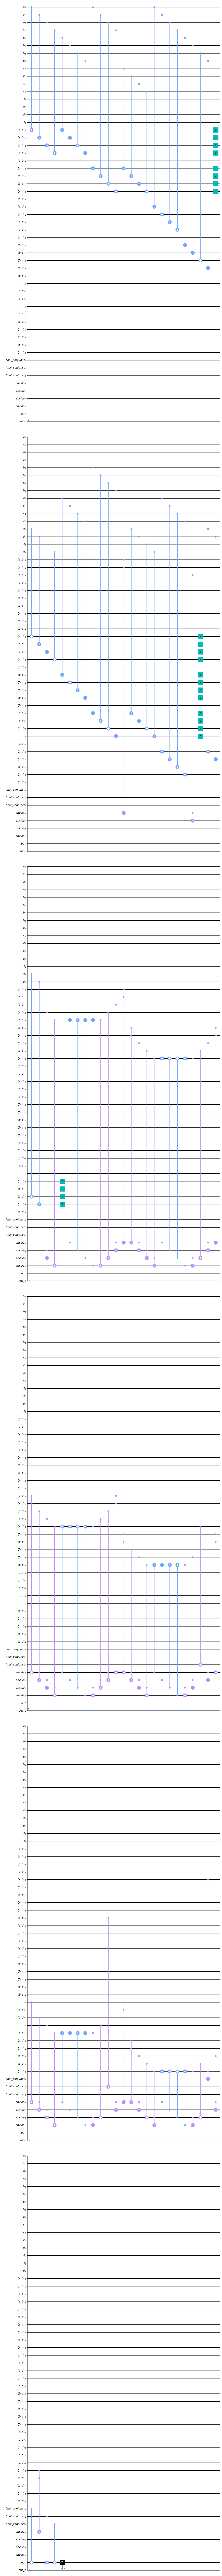

In [ ]:
from qiskit.circuit.quantumcircuit import Clbit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

a_reg = QuantumRegister(4, 'a')
b_reg = QuantumRegister(4, 'b')
c_reg = QuantumRegister(4, 'c')
d_reg = QuantumRegister(4, 'd')

ab_conjunct = QuantumRegister(5, '(a.b)')
ac_conjunct = QuantumRegister(5, '(a.c)')
ad_conjunct = QuantumRegister(5, '(a.d)')
bc_conjunct = QuantumRegister(5, '(b.c)')
bd_conjunct = QuantumRegister(5, '(b.d)')
cd_conjunct = QuantumRegister(5, '(c.d)')

out = QuantumRegister(1, 'out')
out_c = ClassicalRegister(1, 'out_c')

conjuncts = [
    ab_conjunct,
    ac_conjunct,
    ad_conjunct,
    bc_conjunct,
    bd_conjunct,
    cd_conjunct
]

final_conjunct = QuantumRegister(3, "final_conjunct")
anc = QuantumRegister(4, 'ancilla')

circuit = QuantumCircuit(
  a_reg, b_reg, c_reg, d_reg, ab_conjunct, ac_conjunct, ad_conjunct,
  bc_conjunct, bd_conjunct, cd_conjunct, final_conjunct, anc, out, out_c
)

circuit.cx(a_reg, ab_conjunct[0:4])
circuit.cx(b_reg, ab_conjunct[0:4])
circuit.cx(a_reg, ac_conjunct[0:4])
circuit.cx(c_reg, ac_conjunct[0:4])
circuit.cx(a_reg, ad_conjunct[0:4])
circuit.cx(d_reg, ad_conjunct[0:4])
circuit.cx(b_reg, bc_conjunct[0:4])
circuit.cx(c_reg, bc_conjunct[0:4])
circuit.cx(b_reg, bd_conjunct[0:4])
circuit.cx(d_reg, bd_conjunct[0:4])
circuit.cx(c_reg, cd_conjunct[0:4])
circuit.cx(d_reg, cd_conjunct[0:4])

for conjunct in conjuncts:
  circuit.z(conjunct[0:4])

  # Compute the ancillae
  circuit.toffoli(conjunct[0], conjunct[1], anc[0])
  for i in range(2, 5):
    circuit.toffoli(conjunct[i], anc[i-2],  anc[i-1])

  # Copy the ancillae
  circuit.cx(anc, conjunct[4])

  # Uncompute the ancillae
  for i in range(4, 1, -1):
    circuit.toffoli(conjunct[i], anc[i-2], anc[i-1])
  circuit.toffoli(conjunct[0], conjunct[1], anc[0])

# Check if any "pairing" of these conjunctions is |1>
circuit.toffoli(ab_conjunct[4], cd_conjunct[4], final_conjunct[0])
circuit.toffoli(ac_conjunct[4], bd_conjunct[4], final_conjunct[1])
circuit.toffoli(ad_conjunct[4], bc_conjunct[4], final_conjunct[2])

circuit.cx(final_conjunct, out) # The setup of final_conjunct means that either 0, 1 or 3 of its registers will be True:
                                # we can use this as a shortcut to simulate an OR gate in this scenario
circuit.measure(out, out_c)

circuit.draw("mpl")

## Quantum circuit for solution 2

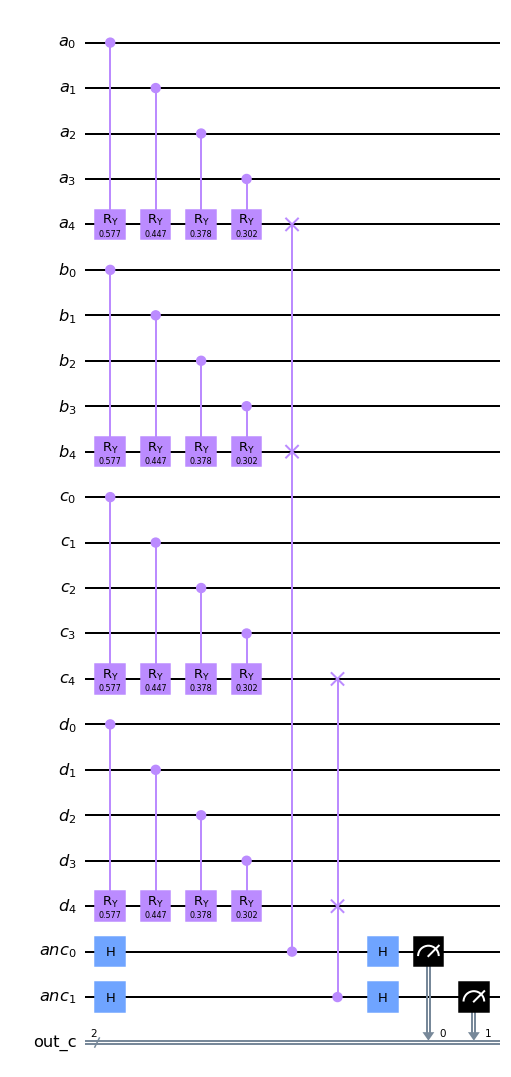

In [ ]:
from qiskit import QuantumCircuit
from math import sqrt

a = 10
b = 10
c = 4
d = 4

def is_rectangle(a, b, c, d):
  pass

a_reg = QuantumRegister(5, 'a')
b_reg = QuantumRegister(5, 'b')
c_reg = QuantumRegister(5, 'c')
d_reg = QuantumRegister(5, 'd')

int_regs = [a_reg, b_reg, c_reg, d_reg]

anc = QuantumRegister(2, 'anc')
out_c = ClassicalRegister(2, 'out_c')

circuit = QuantumCircuit(
  a_reg, b_reg, c_reg, d_reg, anc, out_c
)

for reg in int_regs:
  # These can be estimated efficiently due to the Solovay–Kitaev theorem
  circuit.cry(1/sqrt(3), reg[0], reg[4])
  circuit.cry(1/sqrt(5), reg[1], reg[4])
  circuit.cry(1/sqrt(7), reg[2], reg[4])
  circuit.cry(1/sqrt(11), reg[3], reg[4])

# Perform the swap test using the ancillary qubits 
circuit.h(anc)
circuit.cswap(anc[0], a_reg[4], b_reg[4])
circuit.cswap(anc[1], c_reg[4], d_reg[4])
circuit.h(anc)

circuit.measure(anc, out_c)

circuit.draw("mpl")

## Quantum circuit for solution 3

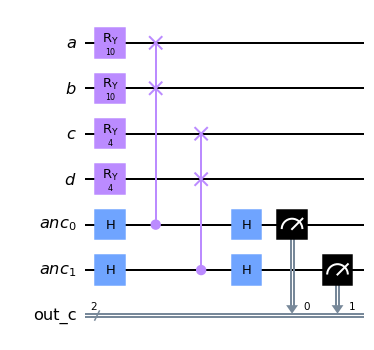

In [ ]:
import numpy as np
from qiskit import QuantumCircuit

a = 10
b = 10
c = 4
d = 4
  
a_reg = QuantumRegister(1, 'a')
b_reg = QuantumRegister(1, 'b')
c_reg = QuantumRegister(1, 'c')
d_reg = QuantumRegister(1, 'd')
anc = QuantumRegister(2, 'anc')
out_c = ClassicalRegister(2, 'out_c')

circuit = QuantumCircuit(
  a_reg, b_reg, c_reg, d_reg, anc, out_c
)

# arcsins have been removed here so that the quantum circuit can be drawn
circuit.ry(a, a_reg)
circuit.ry(b, b_reg)
circuit.ry(c, c_reg)
circuit.ry(d, d_reg)

# Perform the swap test using the ancillary qubits 
circuit.h(anc)
circuit.cswap(anc[0], a_reg, b_reg)
circuit.cswap(anc[1], c_reg, d_reg)
circuit.h(anc)

circuit.measure(anc, out_c)

circuit.draw("mpl")

## Unit tests

In [ ]:
def unit_test(a, b, c, d):
  expected = (a == b and c == d) or (a == c and b == d) or (a == d and b == c)
  
  assert is_rectangle(a, b, c, d) == expected, f"Incorrect value: Expected {expected} for {a}, {b}, {c}, {d} but got {not expected}"

unit_test(1, 2, 10, 10)
unit_test(10, 9, 10, 9)
unit_test(10, 10, 10, 10)

AssertionError: ignored